### ME 574 Winter 2019 Homework 4 Solution

In [1]:
from numba import cuda, float32, float64
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time

**1) Consider the integral $I = \int_{0}^{1} \frac{dx}{x^2 + 1}$ that was previously treated in Homework 2.**  

**a) Create a shared memory implementation of Simpson's rule to evaluate $I$.** 

**Solution:**

In [2]:
@cuda.jit
def shared_simpson(d_f, d_diff):
    sh_f = cuda.shared.array(NSHARED, dtype = float64) # allocate shared array
    stencil = cuda.const.array_like(STENCIL) # this copies the STENCIL array into constant memory
    # establish index values
    i = cuda.grid(1) # global grid index
    tIdx = cuda.threadIdx.x # thread index (and index into static shared output array)
    shIdx = tIdx + RAD # index in shared input array (with "gap" to accommodate halo cells)
    n = d_f.shape[0]
    if i>=n:
        return # nothing needs to be done beyond range of input array

    #Load regular cells
    sh_f[shIdx] = d_f[i]

    #Halo cells- Check that the entries to be loaded are within array bounds
    if tIdx < RAD: # first RAD threads do all the halos loading work
        if i >= RAD: # if a halo values exists RAD places to the left, load it
            sh_f[shIdx - RAD] = d_f[i-RAD] 
        if i + cuda.blockDim.x < n: # if a halo values exists blockDim.x-RAD places to the right, load it
            sh_f[shIdx + cuda.blockDim.x] = d_f[i + cuda.blockDim.x] 

    cuda.syncthreads() # synchronize to make sure shared array is fully populated before reading from it!
    '''
    Now that all relevant data has been read from global memory ONCE and stored in shared memory, 
    perform the computation as before (but using sh_f[shIdx] instead of d_f[i])
    '''
    # Only write values where the full stencil is "in bounds"
    # This looks just like before but for general value of RAD (not necessarily 1) and with "paired summation"
    if i >= RAD and i < n-RAD and (i-RAD)%(2*RAD) == 0:
        tmp = sh_f[shIdx  ]*stencil[RAD]
        for di in range(1,RAD+1):
            tmp += sh_f[shIdx-di]*stencil[RAD-di] + sh_f[shIdx+di]*stencil[RAD+di]
        d_diff[i] = tmp

**b) Verify that the output agrees with that of your previous serial evaluation (with corresponding grid spacing $h$).**

**Solution:**

In [3]:
@cuda.reduce
def sum_reduce(a, b):
    return a + b

In [4]:
def shared_simpson_wrapper(f, h):
    d_f = cuda.to_device(f)
    diff = np.zeros(f.shape)
    d_diff = cuda.to_device(diff)
    BPG = (f.size-1)//TPB+1
    shared_simpson[TPB, BPG](d_f, d_diff)
#     diff = d_diff.copy_to_host()
#     assert(diff[0] == 0)
#     assert(diff[-1] == 0)
    return sum_reduce(d_diff) * h / 3

In [5]:
def serial_simpson(f, h):
    integral = 0
    for j in range(0, len(f)-1, 2):
        integral += (f[j]+4*f[j+1]+f[j+2])
    return integral * h / 3

In [6]:
TPB = 2048
RAD = 1
NSHARED = TPB + 2*RAD
STENCIL = np.array([1., 4., 1.])

In [7]:
m = 10**np.arange(1, 4)
h = 1 / m
for i in range(len(m)):
    x = np.linspace(0, 1, m[i]+1)
    f = 1 / (x**2+1)
    print(f'step size {h[i]} error {serial_simpson(f, h[i])-shared_simpson_wrapper(f, h[i])}')

step size 0.1 error 0.0
step size 0.01 error 0.0
step size 0.001 error 5.551115123125783e-16


We can see that for $n = 1, 2, 3$ there are no difference between the results of serial implementation and shared memory implementation.

**c) Present a plot of computation times for serial, parallel (using global memory), and parallel (using shared memory) evaluation as a function of $h$. Briefly discuss the salient features of your results.**

**Solution:**

In [8]:
@cuda.jit
def para_simpson(d_f, d_diff):
    i = cuda.grid(1)
    if i < d_f.shape[0] and i%2 == 1:
        d_diff[i] = d_f[i-1] + 4*d_f[i] + d_f[i+1]

In [9]:
def para_simpson_wrapper(f, h):
    d_f = cuda.to_device(f)
    diff = np.zeros(f.shape)
    d_diff = cuda.to_device(diff)
    BPG = (f.size-1)//TPB+1
    para_simpson[TPB, BPG](d_f, d_diff)
    return sum_reduce(d_diff) * h / 3

In [10]:
m = 10**np.arange(1, 7)
h = 1 / m
serial_times, para_times, shared_times = [], [], []
for i in range(len(m)):
    x = np.linspace(0, 1, m[i]+1)
    f = 1 / (x**2+1)
    t0 = time.time()
    serial_simpson(f, h[i])
    t1 = time.time()
    para_simpson_wrapper(f, h[i])
    t2 = time.time()
    shared_simpson_wrapper(f, h[i])
    t3 = time.time()
    serial_times.append(t1-t0)
    para_times.append(t2-t1)
    shared_times.append(t3-t2)

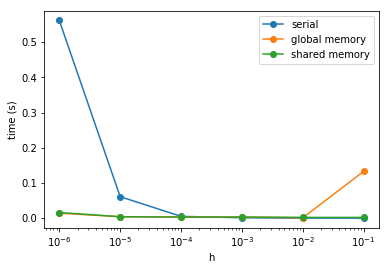

In [12]:
plt.plot(h, serial_times, '-o', label='serial')
plt.plot(h, para_times, '-o', label='global memory')
plt.plot(h, shared_times, '-o', label='shared memory')
plt.legend()
plt.xlabel('h')
plt.ylabel('time (s)')
plt.xscale('log')
plt.show()

From the plot we can see that:  
1) All implementations are fast when $h$ is large.  
2) As $h$ gets smaller, the serial implementation takes obviously more time, while the two parallel implementations are still very fast.  
3) There's no noticeable differences between time costs of the two parallel implementations. One possible reason is that the computation load is still too little to see the difference.  
4) The time cost at $n=1$ of the global memory implementation is large. I tried switch the order and time the shared memory implementation before the global memory implementation, then the large time cost appears in the shared memory implementation. One possible reason I think is the time cost of compilation.

**2) Read the first notebook __"Introduction to numerical solution of PDEs"__  from lesson 2 __"Space & Time"__ of the Numerical Methods MOOC by Barba et al.**

**a) Consider the following code from Part 1**
```python
u = u0.copy()
for n in range(1, nt):
    un = u.copy()
    for i in range(1, nx):
        u[i] = un[i] - c * dt / dx * (un[i] - un[i - 1])
```
Identify the `for` loop that is a candidate for parallelization. Explain your choice and implement code to parallelize it.

**Solution:**

The inner `for` loop (space loop) is a candidate for parallelization. We choose space because at a fixed time, the function values at different locations are independent from each other. On the contrary, at a fixed location, the function value at a time spot depends on the function value at the previous time spot, so the time loop cannot be paralleled.

In [13]:
@cuda.jit
def space_kernel(d_un, d_u, c, dt, dx):
    i = cuda.grid(1)
    n = d_u.shape[0]
    if i > 0 and i < n:
        d_u[i] = d_un[i] - c * dt / dx * (d_un[i] - d_un[i - 1])

**b) Use your parallel code (together with the code for producting the plot) to answer the question under the first ___Dig Deeper___ heading: Does reducing the stepsize recover the shape of the square-wave input?**

**Solution:**

In [14]:
# Set parameters.
nx = 41  # number of spatial discrete points
L = 2.0  # length of the 1D domain
dx = L / (nx - 1)  # spatial grid size
nt = 500  # number of time steps
dt = 0.001  # time-step size
c = 1.0  # convection speed

# Define the grid point coordinates.
x = np.linspace(0.0, L, num=nx)

In [15]:
# Set initial conditions with 1.0 everywhere (for now).
u0 = np.ones(nx)
# Get a list of indices where 0.5 <= x <= 1.0.
mask = np.where(np.logical_and(x >= 0.5, x <= 1.0))
print(mask)

(array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], dtype=int64),)


In [16]:
# Set initial condition u = 2.0 where 0.5 <= x <= 1.0.
u0[mask] = 2.0
print(u0)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [17]:
TPB = 32
u = u0.copy()
for n in range(1, nt):
    d_un = cuda.to_device(u)
    d_u = cuda.to_device(u)
    space_kernel[TPB, (u.shape[0]-1)//TPB+1](d_un, d_u, c, dt, dx)
    u = d_u.copy_to_host()

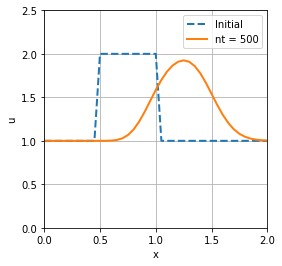

In [18]:
# Plot the solution after nt time steps
# along with the initial conditions.
plt.figure(figsize=(4.0, 4.0))
plt.xlabel('x')
plt.ylabel('u')
plt.grid()
plt.plot(x, u0, label='Initial',
            color='C0', linestyle='--', linewidth=2)
plt.plot(x, u, label='nt = {}'.format(nt),
            color='C1', linestyle='-', linewidth=2)
plt.legend()
plt.xlim(0.0, L)
plt.ylim(0.0, 2.5);

We try to reduce the time stepsize to 0.001 and also change the number of time steps to keep the same time range. From the plot we can see that it does not help recovering the square wave.

**c) Modify your parallel code to include non-linear convection to model the 1D convection equation:
$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = 0$
<br>Execute your code to re-create the figure above the second ___Dig Deeper___ heading.**

**Solution:**

In [19]:
@cuda.jit
def space_kernel_nonlinear(d_un, d_u, dt, dx):
    i = cuda.grid(1)
    n = d_u.shape[0]
    if i > 0 and i < n:
        d_u[i] = d_un[i] - d_un[i] * dt / dx * (d_un[i] - d_un[i - 1])

In [20]:
# Set parameters.
nx = 41  # number of spatial discrete points
L = 2.0  # length of the 1D domain
dx = L / (nx - 1)  # spatial grid size
nt = 10  # number of time steps
dt = 0.02  # time-step size

x = np.linspace(0.0, L, num=nx)
u0 = np.ones(nx)
mask = np.where(np.logical_and(x >= 0.5, x <= 1.0))
u0[mask] = 2.0

In [21]:
TPB = 32
u = u0.copy()
for n in range(1, nt):
    d_un = cuda.to_device(u)
    d_u = cuda.to_device(u)
    space_kernel_nonlinear[TPB, (u.shape[0]-1)//TPB+1](d_un, d_u, dt, dx)
    u = d_u.copy_to_host()

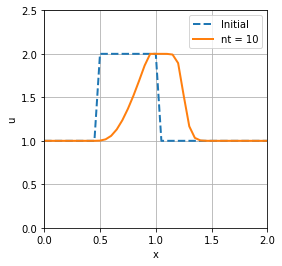

In [22]:
# Plot the solution after nt time steps
# along with the initial conditions.
plt.figure(figsize=(4.0, 4.0))
plt.xlabel('x')
plt.ylabel('u')
plt.grid()
plt.plot(x, u0, label='Initial',
            color='C0', linestyle='--', linewidth=2)
plt.plot(x, u, label='nt = {}'.format(nt),
            color='C1', linestyle='-', linewidth=2)
plt.legend()
plt.xlim(0.0, L)
plt.ylim(0.0, 2.5);

**3) Read the first notebook __"Stability and the CFL condition"__  from lesson 2 __"Space & Time"__ of the Numerical Methods MOOC by Barba et al.**

**a) Implement a revised version of the `linear_convection()` function that performs one timestep in parallel. 
<br>Test your code by creating plots of `linear_convection(65)` and `linear_convection(129)`.**

**Solution:**

In [23]:
def linear_convection_para(nx, L=2.0, c=1.0, dt=0.025, nt=20, tpb=32):
    """
    Solves the 1D linear convection equation
    with constant speed c in the domain [0, L]
    and plots the solution (along with the initial conditions).

    Parameters
    ----------
    nx : integer
        Number of grid points to discretize the domain.
    L : float, optional
        Length of the domain; default: 2.0.
    c : float, optional
        Convection speed; default: 1.0.
    dt : float, optional
        Time-step size; default: 0.025.
    nt : integer, optional
        Number of time steps to compute; default: 20.
    """
    # Discretize spatial grid.
    dx = L / (nx - 1)
    x = np.linspace(0.0, L, num=nx)
    # Set initial conditions.
    u0 = np.ones(nx)
    mask = np.where(np.logical_and(x >= 0.5, x <= 1.0))
    u0[mask] = 2.0
    # Integrate the solution in time.
    u = u0.copy()
    for n in range(1, nt):
        d_un = cuda.to_device(u)
        d_u = cuda.to_device(u)
        space_kernel[tpb, (nx-1)//tpb+1](d_un, d_u, c, dt, dx)
        u = d_u.copy_to_host()
    # Plot the solution along with the initial conditions.
    plt.figure(figsize=(4.0, 4.0))
    plt.xlabel('x')
    plt.ylabel('u')
    plt.grid()
    plt.plot(x, u0, label='Initial',
                color='C0', linestyle='--', linewidth=2)
    plt.plot(x, u, label='nt = {}'.format(nt),
                color='C1', linestyle='-', linewidth=2)
    plt.legend()
    plt.xlim(0.0, L)
    plt.ylim(0.0, 2.5);

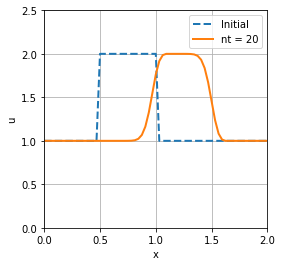

In [24]:
linear_convection_para(65)

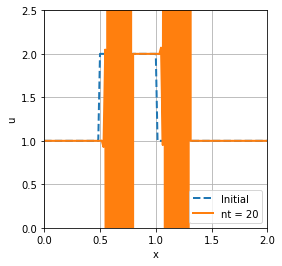

In [25]:
linear_convection_para(129)

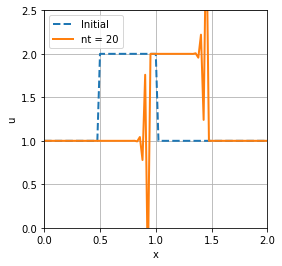

In [26]:
# linear_convection_para(85)

**b) Carefully read the __"What Happened?"__ section, then combine your parallel timestep code with the ___defensively written___ code implementing the CFL condition.
<br>Execute your resulting code to create a plot of `linear_convection(129)`. Briefly compare and contrast this result from the corresponding plot you produced for part a.**

**Solution:**

In [27]:
def linear_convection_defensive_para(nx, L=2.0, c=1.0, sigma=0.5, nt=20, tpb=32):
    """
    Solves the 1D linear convection equation
    with constant speed c in the domain [0, L]
    and plots the solution (along with the initial conditions).

    Parameters
    ----------
    nx : integer
        Number of grid points to discretize the domain.
    L : float, optional
        Length of the domain; default: 2.0.
    c : float, optional
        Convection speed; default: 1.0.
    dt : float, optional
        Time-step size; default: 0.025.
    nt : integer, optional
        Number of time steps to compute; default: 20.
    """
    # Discretize spatial grid.
    dx = L / (nx - 1)
    x = np.linspace(0.0, L, num=nx)
    # Compute the time-step size based on the CFL constraint.
    dt = sigma * dx / c
    # Set initial conditions.
    u0 = np.ones(nx)
    mask = np.where(np.logical_and(x >= 0.5, x <= 1.0))
    u0[mask] = 2.0
    # Integrate the solution in time.
    u = u0.copy()
    for n in range(1, nt):
        d_un = cuda.to_device(u)
        d_u = cuda.to_device(u)
        space_kernel[tpb, (nx-1)//tpb+1](d_un, d_u, c, dt, dx)
        u = d_u.copy_to_host()
    # Plot the solution along with the initial conditions.
    plt.figure(figsize=(4.0, 4.0))
    plt.xlabel('x')
    plt.ylabel('u')
    plt.grid()
    plt.plot(x, u0, label='Initial',
                color='C0', linestyle='--', linewidth=2)
    plt.plot(x, u, label='nt = {}'.format(nt),
                color='C1', linestyle='-', linewidth=2)
    plt.legend()
    plt.xlim(0.0, L)
    plt.ylim(0.0, 2.5);

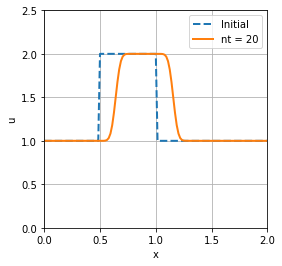

In [28]:
linear_convection_defensive_para(129)

Apparently with the defensively chosen time stepsize, the unstable situation is fixed and we get a nice result.

**4) Consider the second order nonlinear ordinary differential equation $x'' -\epsilon (1 -x^2) x' + x = 0$ for some value of $\epsilon$ such that $0.1 < \epsilon < 2$.**

**a) Re-write the ODE as a system of first order ODEs for $x(t)$ and $v = x' = \frac{dx(t)}{dt}$, and immplement a 4th order Runge-Kutta (RK4) ODE solver to simulate your first order system. 
<br>Test your solve by computing (and plotting) the solution corresponding to the initial conditions $x(0) = 1, v(0) = 0$ on the interval $0 < t < 30$. Plot both $x(t)$ vs. $t$ and the "phase plane" version $y(t)$ vs. $x(t)$.**

**Solution:**

Define $X = [x, v]^T$, we have
$$
X' = \begin{bmatrix}
x' \\
x''
\end{bmatrix} = \begin{bmatrix}
v \\
\epsilon (1 -x^2) v - x
\end{bmatrix} = \begin{bmatrix}
0 & 1 \\
-1 & \epsilon(1 -x^2)
\end{bmatrix}X
$$

In [29]:
def deriv_X(X, eps=1):
    return np.array([[0, 1], [-1, eps*(1-X[0]**2)]]).dot(X)

In [30]:
def rk4_iter_dX(X, dt):
    k1 = dt * deriv_X(X)
    X2 = X + 0.5*k1
    k2 = dt * deriv_X(X2)
    X3 = X + 0.5*k2
    k3 = dt * deriv_X(X3)
    X4 = X + k3
    k4 = dt * deriv_X(X4)
    return (k1+2*k2+2*k3+k4)/6

In [31]:
# setting
dt = 0.01
T = 30
X0 = np.array([[1.], [0.]])
# time
nt = int(T/dt)
t = np.linspace(0, T, nt+1)
# solve
X = [X0]
for i in range(nt):
    X_new = X0 + rk4_iter_dX(X0, dt)
    X.append(X_new)
    X0 = X_new
X = np.concatenate(X, 1)

Text(0, 0.5, 'x(t)')

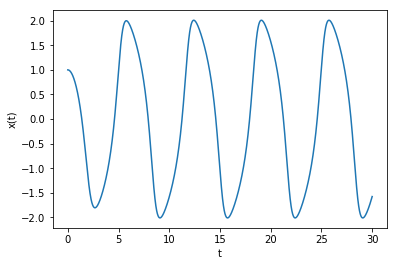

In [32]:
plt.plot(t, X[0,:])
plt.xlabel('t')
plt.ylabel('x(t)')

Text(0, 0.5, 'v(t)')

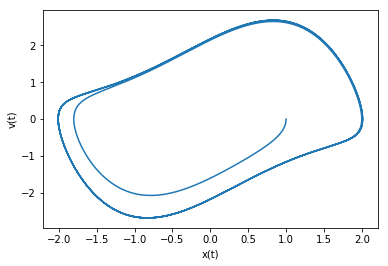

In [33]:
plt.plot(X[0,:], X[1,:])
plt.xlabel('x(t)')
plt.ylabel('v(t)')

**b) Write the necessary code to launch and execute a parallel kernel to compute the change in $x$ and $v$ during ONE time step of the solution for a 2D grid of initial values $x, v \in [-4,4]$. 
<br>Plot your results as a phase portrait using `matplotlib`'s `quiver` function. 
<br>Briefly discuss how your phase portrait relates to your plots of $x(t)$ from part b.**

**Solution:**

In [34]:
@cuda.jit(device=True)
def d_deriv_v(x, v, eps):
    return eps*(1-x**2)*v - x

In [35]:
@cuda.jit
def d_rk4_iter_dX(d_x, d_v, d_dx, d_dv, dt, eps):
    i, j = cuda.grid(2)
    if i < d_x.shape[0] and j < d_v.shape[0]:
        x = d_x[i, j]
        v = d_v[i, j]
        k1x = dt * v
        k1v = dt * d_deriv_v(x, v, eps)
        x2 = x + 0.5*k1x
        v2 = v + 0.5*k1v
        k2x = dt * v2
        k2v = dt * d_deriv_v(x2, v2, eps)
        x3 = x + 0.5*k2x
        v3 = v + 0.5*k2v
        k3x = dt * v3
        k3v = dt * d_deriv_v(x3, v3, eps)
        x4 = x + k3x
        v4 = v + k3v
        k4x = dt * v4
        k4v = dt * d_deriv_v(x4, v4, eps)
        d_dx[i, j] = (k1x+2*k2x+2*k3x+k4x)/6
        d_dv[i, j] = (k1v+2*k2v+2*k3v+k4v)/6

In [36]:
# setting
n = 21
x = np.linspace(-4, 4, n)
v = x
x, v = np.meshgrid(x, v)
eps = 1
# compute
TPB = 32
BPG = (n-1)//TPB+1
d_x = cuda.to_device(x)
d_v = cuda.to_device(v)
d_dx = cuda.device_array(x.shape)
d_dv = cuda.device_array(v.shape)
d_rk4_iter_dX[[TPB, TPB], [BPG, BPG]](d_x, d_v, d_dx, d_dv, dt, eps)
dx = d_dx.copy_to_host()
dv = d_dv.copy_to_host()

Text(0, 0.5, 'v(t)')

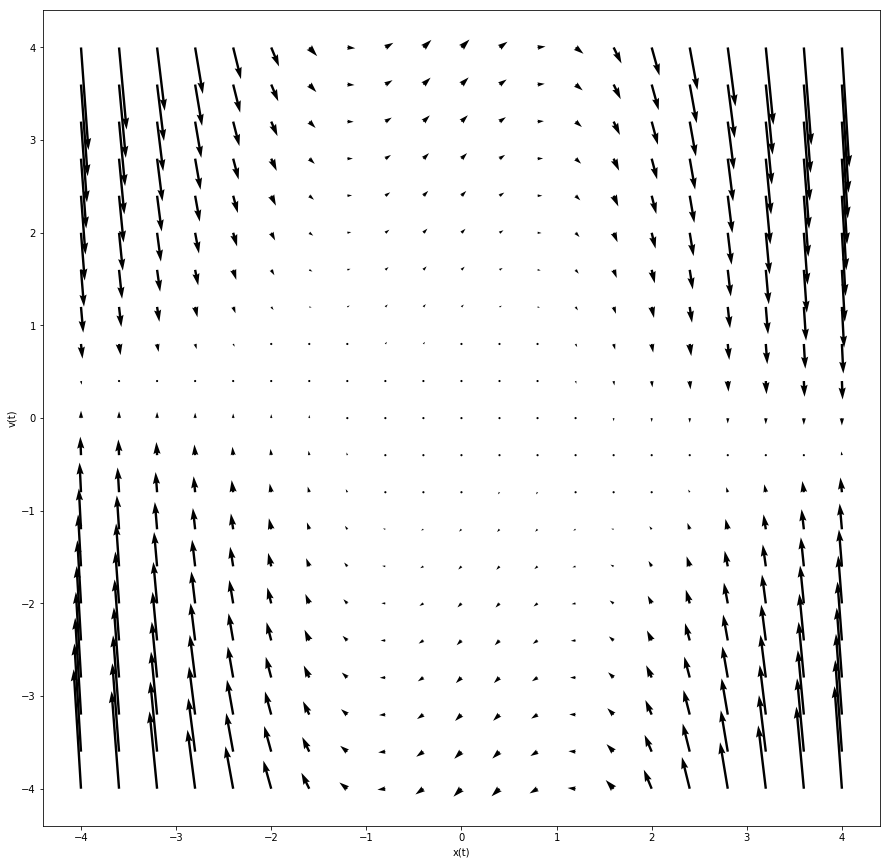

In [37]:
plt.figure(figsize=(15, 15))
plt.quiver(x, v, dx, dv)
plt.xlabel('x(t)')
plt.ylabel('v(t)')

From the plot, we can see that the system is likely to cycle following the arrows in the clockwise direction given initial condition $x(0)=1$ and $v(0)=0$. This explains both the cycling behavior of the phase plot and the oscillating behavior of the $x(t)$ plot in (a).